## Metodo dei Gradienti Coniugati

L'algoritmo dei gradienti coniugati (CG) è un algoritmo di algebra lineare fondamentale per risolvere sistemi lineari della forma:

$$
Ax = y,
$$

particolarmente efficace quando la matrice $A$ è **grande** e **sparsa** (ovvero, con tanti elementi nulli). Tale algoritmo è però più comunemente utilizzato per risolvere il problema ai minimi quadrati:

$$
\min_{x \in \mathbb{R}^n} \frac{1}{2} || Ax - y ||_2^2,
⁡$$

senza fare uso *esplicitamente* delle equazioni normali (a differenza di quanto avevamo visto per i metodi SVD, Cholesky e Discesa del Gradiente). Quando L'algoritmo CG viene applicato a problemi ai minimi quadrati, prende il nome di CGLS (Conjugate Gradient Least Squares). Uno dei vantaggi principali di CGLS, rispetto agli algoritmi precedentemente studiati è il fatto che, non facendo uso delle equazioni normali, questo si comporta molto meglio quando la matrice $A$ è molto mal condizionata. Infatti, è noto che:

$$
k_2(A^T A) = k_2(A)^2,
$$

e quindi se $A$ è mal condizionata, allora il numero di condizionamento della matrice delle equazioni normali $A^T A$ è molto più grande, portando ad un'amplificazione degli errori numerici.

Come tutti gli algoritmi comunemente utilizzati per risolvere problemi di Algebra Lineare, CGLS è un algoritmo **iterativo**, e richiede perciò nella sua implementazione di scegliere un'iterato iniziare (da cui partire per trovare la soluzione), un numero massimo di passi iterativi (per evitare che l'algoritmo possa entrare in un loop senza fine), e di un criterio di arresto. Vedremo nella prossima sezione come scegliere queste componenti.

## Implementazione
L'implementazione dell'algoritmo CGLS è abbastanza complessa e sfrutta alcuni cavilli implementativi per massimizzarne l'efficienza. Per quanto ci riguarda, è sufficiente notare due aspetti fondamentali di tale algoritmo, che saranno particolarmente chiave per la sua applicazione all'imaging:

1. L'algoritmo fa uso della matrice $A$ solo all'interno di operazioni del tipo $Ax$ oppure $A^T z$.
2. L'algoritmo utilizza il minimo numero possibile di operazioni del tipo $Ax$ e $A^T z$.

Queste due proprietà sono fondamentali per applicazioni dove la matrice $A$ è veramente molto grande (ad esempio nei problemi di imaging, dove la dimensione $(m, n)$ di $A$ è dell'ordine dei milioni di righe per milioni di colonne). Infatti, in questi casi, memorizzare esplicitamente la matrice $A$ in memoria può essere proibitivo, e spesso è possibile utilizzare ad $A$ solo tramite algoritmi ottimizzati che, però, permettono di accedere solo ad operazioni del tipo $Ax$ o $A^T z$. Questo implica, inoltre, che il calcolo di operazioni matrice-vettore che contengono la matrice $A$ sono spesso il collo di bottiglia dell'algoritmo, in termini di efficienza. Per questo motivo, minimizzare il numero di applicazioni di $A$, rende l'algoritmo molto più efficiente.

Andiamo quindi a discutere gli step principali dell'algoritmo, e a vederne un'implementazione in Python.

**Inizializzazione:** Dato un'iterato iniziale $x_0 \in \mathbb{R}^n$ a libera scelta (spesso, per comodità, scelto essere uguale al vettore di zeri), si calcola:

* Il residuo iniziale $r_0 = A^T(y - Ax_0)$;
* Il vettore direzione iniziale $p_0 = r_0$.

**Aggiornamento:** Per ogni $k = 0, 1, \dots, \texttt{maxit}$:

* Calcola il vettore $q_k = Ap_k$,
* Calcola il parametro $\alpha_k = \frac{|| r_k ||_2^2}{|| q_k ||_2^2}$,
* Aggiorna la soluzione $x_{k+1} = x_k + \alpha_k p_k$,
* Aggiorna il residuo $r_{k+1} = r_k - \alpha_k A^T q_k$,
* Calcola il parametro $\beta_k = \frac{|| r_{k+1} ||_2^2}{|| r_k ||_2^2}$,
* Aggiora la direzione $p_{k+1} = r_k + \beta_k p_k$.

## Condizioni di arresto
Il critero di arresto tipico di CGLS è differente da quelli a cui siete stati abituati da altri algoritmi iterativi come ad esempio il metodo di discesa del gradiente o i metodi degli zeri. Infatti, essendo stato sviluppato specificatamente per risolvere problemi ai minimi quadrati, il suo criterio di arresto si basa sul controllare se il residuo $r_k = A^T(y - Ax_k)$ (che è la quantità che si vuole minimizzare) abbia norma minore o uguale ad una tolleranza fissata. In particolare, dato un valore di $\texttt{tol} > 0$, si interrompe l'algoritmo per quel valore di $k$ tale che:

$$
|| r_k ||_2 < \texttt{tol} \cdot || r_0 ||_2.
$$

Siamo quindi pronti a vedere un'implementazione Python di tale algoritmo:

In [12]:
import numpy as np

def cgls(A, y, tol=1e-5, maxit=100):
    # Inizializzazione
    x = np.zeros(A.shape[1])  # x0 = 0
    r = r0 = A.T @ (y - A @ x)     # residuo iniziale
    p = r.copy()              # direzione iniziale
    
    for k in range(maxit):
        # Calcolo valori richiesti
        q = A @ p
        alpha = np.linalg.norm(r)**2 / np.linalg.norm(q)**2

        # Aggiornamento di x e di r
        x = x + alpha * p
        r_new = r - alpha * A.T @ q
        
        # Criterio di arresto
        if np.linalg.norm(r_new) < tol * np.linalg.norm(r0):
            print(f'Convergenza raggiunta in {k+1} iterazioni.')
            break
        
        # Aggiornamento dei parametri
        beta = np.linalg.norm(r_new)**2 / np.linalg.norm(r)**2
        p = r_new + beta * p
        r = r_new
    
    return x

## Convergenza dell'algoritmo CGLS
Un'interessante proprietà dell'algoritmo CGLS riguarda la sua convergenza. Infatti, a differenza degli altri algoritmi iterativi visti a lezione la cui convergenza avveniva a infinito (ovvero, per ottenere la soluzione **esatta**, era necessario iterare il problema infinite volte), CGLS gode della seguente proprietà:

> Se $A \in \mathbb{R}^{m \times n}$, allora l'algoritmo CGLS convergerà alla soluzione **esatta** del problema ai minimi quadrati in **al massimo** $n$ iterazioni.

Di conseguenza, è sempre possibile scegliere `maxit`$ = n$, avendo la certezza *teorica* che l'algoritmo terminerà per il criterio d'arresto entro il valore fissato di `maxit`. 

## CGLS per minimi quadrati regolarizzati (con Tikhonov)
L'algoritmo CGLS sopra proposto può essere facilmente modificato per risolvere problemi ai minimi quadrati regolarizzati con Tikhonov, già trattati precedentemente, della forma:

$$
\min_{x} \frac{1}{2} || Ax - y ||_2^2 + \frac{\lambda}{2} || Lx ||_2^2,
$$

dove $L \in \mathbb{R}^{d \times n}$ è la matrice di Tikhonov, spesso scelta uguale alla matrice identità, per semplicità, e $\lambda > 0$ è il parametro di regolarizzazione. Abbiamo già visto come questo problema ha equazioni normali:

$$
(A^T A + \lambda L^T L) x = A^T y,
$$

e può quindi essere risolto con CGLS, facendo attenzione al termine $\lambda L^T L$ che non era precedentemente presente. Il codice Python modificato per CGLS regolarizzato diventa quindi:

In [13]:
import numpy as np

def cgls_tikhonov(A, y, L, lam, tol=1e-6, maxit=100):
    """
    Algoritmo CGLS per risolvere il problema ai minimi quadrati regolarizzati con Tikhonov:
    min_x (1/2) * ||Ax - y||_2^2 + (lam/2) * ||Lx||_2^2
    """
    # Inizializzazione
    x = np.zeros(A.shape[1])
    r = r0 = y - A @ x
    p = A.T @ r - lam * (L.T @ (L @ x)) 
    z = p.copy() # z prende il posto di "p" come direzione

    for k in range(maxit):
        # Calcolo valori richiesti
        q = A @ p
        t = L @ p
        alpha = np.linalg.norm(z)**2 / np.linalg.norm(q)**2
        
        # Calcolo del coefficiente alpha
        alpha = (z.T @ z) / (q.T @ q + lam * (t.T @ t))
        
        # Aggiornamento di x
        x = x + alpha * p
        
        # Aggiornamento del residuo
        r = r - alpha * q
        
        # Verifica del criterio di arresto
        if np.linalg.norm(r) < tol * np.linalg.norm(r0):
            break
        
        # Calcolo della nuova direzione z
        z_new = A.T @ r - lam * (L.T @ (L @ x))
        
        # Calcolo del coefficiente beta
        beta = np.linalg.norm(z_new)**2 / np.linalg.norm(z)**2
        
        # Aggiornamento della direzione p
        p = z_new + beta * p
        z = z_new

    return x

Da notare come la versione aggiornata di CGLS per regolarizzazione con Tikhonov differisce da quella standard praticamente solo nel fatto che, al posto del residuo classico, si utilizza un residuo *modificato* che tiene in considerazione la matrice $L$. Tale termine è indicato con `z` nell'algoritmo sopra.

Vediamo come utilizzare le due versioni di CGLS proposte.

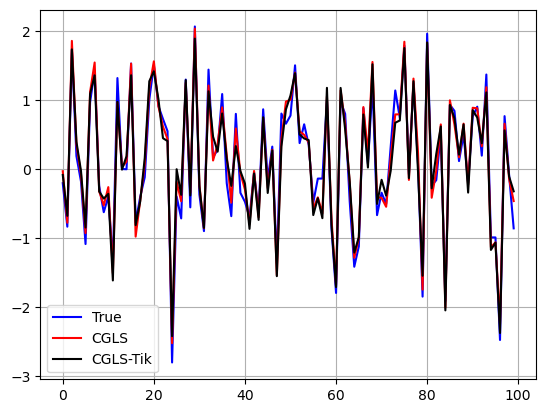

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Applichiamo CGLS per la risoluzione di un problema ai minimi quadrati (regolarizzato e non).
n = 100 # dimensione del problema (matrice A quadrata di dimensione n x n)
np.random.seed(0) # impostiamo un seed (per la riproducibilità)

# Problema test
A = np.random.randn(n, n)
L = np.eye(n)
x_true = np.random.randn(n)
y = A @ x_true + 0.05 * np.random.randn(n)  # Vettore di osservazioni con rumore

lam = 0.1  # Parametro di regolarizzazione

# Risoluzione del problema con CGLS standard
x_cgls = cgls(A, y, maxit=100)

# Risoluzione del problema con CGLS regolarizzato
x_cgls_tik = cgls_tikhonov(A, y, L, lam, maxit=100)

# Visualizziamo le soluzioni
plt.plot(x_true, 'b-')
plt.plot(x_cgls, 'r-')
plt.plot(x_cgls_tik, 'k-')
plt.grid()
plt.legend(["True", "CGLS", "CGLS-Tik"])
plt.show()